# Practical Text Classification With Python and Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_palette('colorblind')
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip

--2020-07-06 09:42:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84188 (82K) [application/x-httpd-php]
Saving to: ‘sentiment labelled sentences.zip’

sentiment labelled  100%[===================>]  82.21K   315KB/s    in 0.3s    

2020-07-06 09:42:42 (315 KB/s) - ‘sentiment labelled sentences.zip’ saved [84188/84188]



In [3]:
import zipfile
with zipfile.ZipFile('/content/sentiment labelled sentences.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sentiment labelled sentences')

In [4]:
filepath_dict = {'yelp': '/content/sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt',
                 'amazon': '/content/sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt',
                 'imdb': '/content/sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [5]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [6]:
sentences = ['John likes ice cream', 'John hates chocolate.']

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'chocolate': 1, 'cream': 2, 'hates': 3, 'ice': 4, 'likes': 5}

In [8]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

## Defining a Baseline Model

When you work with machine learning, one important step is to define a baseline model. This usually involves a simple model, which is then used as a comparison with the more advanced models that you want to test. In this case, you’ll use the baseline model to compare it to the more advanced methods involving (deep) neural networks, the meat and potatoes of this tutorial.

Overfitting is when a model is trained too well on the training data. You want to avoid overfitting, as this would mean that the model mostly just memorized the training data. This would account for a large accuracy with the training data but a low accuracy in the testing data.

In [9]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer 

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)
X_train.shape

(750, 1728)

In [11]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print('Accuracy score: ', score)

Accuracy score:  0.816


In [12]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence']
    y = df_source['label']

    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2)
    vec = CountVectorizer(stop_words='english')
    X_train = vec.fit_transform(sentences_train)
    X_test = vec.transform(sentences_test)

    lr = LogisticRegression().fit(X_train, y_train)
    score = lr.score(X_test, y_test)

    print(f'Accuracy score for {source} data: {score:.4f}')

Accuracy score for yelp data: 0.8050
Accuracy score for amazon data: 0.8050
Accuracy score for imdb data: 0.7333


## Introducing Keras

Now you are finally ready to experiment with Keras. Keras supports two main types of models. You have the Sequential model API which you are going to see in use in this tutorial and the functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer with all the weights and biases that you are already familiar with.

In [13]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                23570     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 23,581
Trainable params: 23,581
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Train on 598 samples, validate on 150 samples
Epoch 1/100
598/598 [==============================] - 2s 3ms/step - loss: 0.6880 - accuracy: 0.5652 - val_loss: 0.6925 - val_accuracy: 0.6000
Epoch 2/100
598/598 [==============================] - 0s 416us/step - loss: 0.6525 - accuracy: 0.7625 - val_loss: 0.6860 - val_accuracy: 0.6667
Epoch 3/100
598/598 [==============================] - 0s 422us/step - loss: 0.5960 - accuracy: 0.8763 - val_loss: 0.6882 - val_accuracy: 0.6867
Epoch 4/100
598/598 [==============================] - 0s 441us/step - loss: 0.5139 - accuracy: 0.9264 - val_loss: 0.6699 - val_accuracy: 0.7133
Epoch 5/100
598/598 [==============================] - 0s 432us/step - loss: 0.4229 - accuracy: 0.9532 - val_loss: 0.6584 - val_accuracy: 0.7467
Epoch 6/100
598/598 [==============================] - 0s 397us/step - loss: 0.3412 - accuracy: 0.9666 - val_loss: 0.6549 - val_accuracy: 0.7667
Epoch 7/100
598/598 [==============================] - 0s 442us/step - loss: 0.2772 - 

In [16]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print(f'Training accuracy: {accuracy:.4f}, Loss: {loss:.4f}')
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f'Test accuracy: {accuracy:.4f}, Loss: {loss:.4f}')

598/598 [==============================] - 0s 84us/step
Training accuracy: 1.0000, Loss: 0.0031
150/150 [==============================] - 0s 92us/step
Test accuracy: 0.7200, Loss: 1.2258


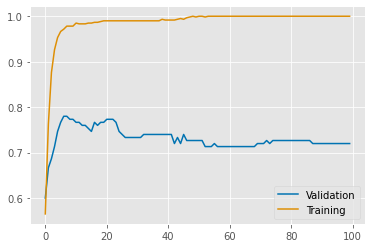

In [17]:
val_hist = history.history['val_accuracy']
acc_hist = history.history['accuracy']

plt.plot(np.arange(0, len(val_hist)), val_hist, label='Validation')
plt.plot(np.arange(0, len(acc_hist)), acc_hist, label='Training')
plt.legend();

In [18]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

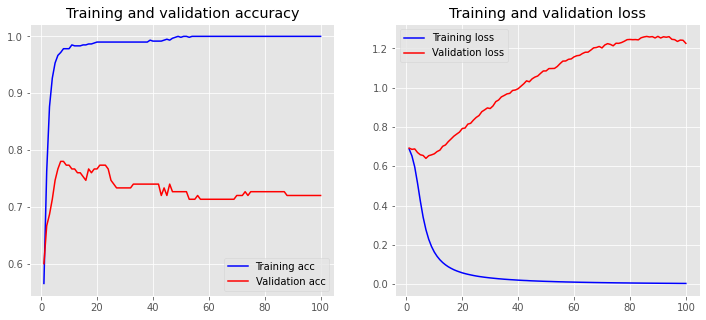

In [20]:
plot_history(history)

## What is Word Embedding?

In [21]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [22]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

In [23]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape(5, 1)
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

### Word Embeddings

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the embedding space.

This would map semantically similar words close on the embedding space like numbers or colors. If the embedding captures the relationship between words well, things like vector arithmetic should become possible. A famous example in this field of study is the ability to map King - Man + Woman = Queen.

In [24]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [25]:
vocab_size

2662

In [26]:
print(sentences_train[21])
print(X_train[21])

If there was ever a movie that needed word-of-mouth to promote, this is it.  
[34, 52, 575, 1003, 10, 1, 11, 14, 30, 116, 576, 9, 36, 34, 2, 52, 1004, 272, 325]


In [27]:
for word in ['the', 'all', 'movie', 'sad']:
    print(f"{word}: {tokenizer.word_index[word]}")

the: 1
all: 28
movie: 11
sad: 1593


In [28]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[0, :])

[  1  56 203   7  12 234  12   1 977  33  30  63 978   1 979  52   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Keras Embedding Layer

Notice that, at this point, our data is still hardcoded. We have not told Keras to learn a new embedding space through successive tasks. Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:
- input_dim: the size of the vocabulary
- output_dim: the size of the dense vector
- input_length: the length of the sequence

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           133100    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 183,121
Trainable params: 183,121
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print(f"Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f"Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 598 samples, validate on 150 samples
Epoch 1/20
598/598 [==============================] - 0s 706us/step - loss: 0.6985 - accuracy: 0.5184 - val_loss: 0.6947 - val_accuracy: 0.4733
Epoch 2/20
598/598 [==============================] - 0s 510us/step - loss: 0.6832 - accuracy: 0.5284 - val_loss: 0.6934 - val_accuracy: 0.4733
Epoch 3/20
598/598 [==============================] - 0s 493us/step - loss: 0.6576 - accuracy: 0.5702 - val_loss: 0.6904 - val_accuracy: 0.4667
Epoch 4/20
598/598 [==============================] - 0s 507us/step - loss: 0.5988 - accuracy: 0.6488 - val_loss: 0.6811 - val_accuracy: 0.4933
Epoch 5/20
598/598 [==============================] - 0s 495us/step - loss: 0.5032 - accuracy: 0.8027 - val_loss: 0.6869 - val_accuracy: 0.4933
Epoch 6/20
598/598 [==============================] - 0s 496us/step - loss: 0.4185 - accuracy: 0.9030 - val_loss: 0.7043 - val_accuracy: 0.5000
Epoch 7/20
598/598 [==============================] - 0s 467us/step - loss: 0.3640 - accur

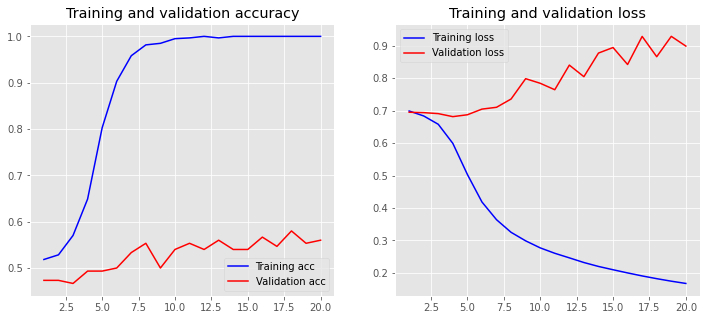

In [31]:
plot_history(history)

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalMaxPool1D, Dense

embedding_dim = 50
maxlen = 100

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           133100    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 133,621
Trainable params: 133,621
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print(f"Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f"Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 598 samples, validate on 150 samples
Epoch 1/20
598/598 [==============================] - 0s 771us/step - loss: 0.6907 - accuracy: 0.5151 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 2/20
598/598 [==============================] - 0s 484us/step - loss: 0.6688 - accuracy: 0.6087 - val_loss: 0.6766 - val_accuracy: 0.5600
Epoch 3/20
598/598 [==============================] - 0s 500us/step - loss: 0.6259 - accuracy: 0.7341 - val_loss: 0.6494 - val_accuracy: 0.6600
Epoch 4/20
598/598 [==============================] - 0s 508us/step - loss: 0.5365 - accuracy: 0.9064 - val_loss: 0.5900 - val_accuracy: 0.7733
Epoch 5/20
598/598 [==============================] - 0s 475us/step - loss: 0.3949 - accuracy: 0.9666 - val_loss: 0.5252 - val_accuracy: 0.7933
Epoch 6/20
598/598 [==============================] - 0s 497us/step - loss: 0.2497 - accuracy: 0.9799 - val_loss: 0.4763 - val_accuracy: 0.7933
Epoch 7/20
598/598 [==============================] - 0s 483us/step - loss: 0.1495 - accur

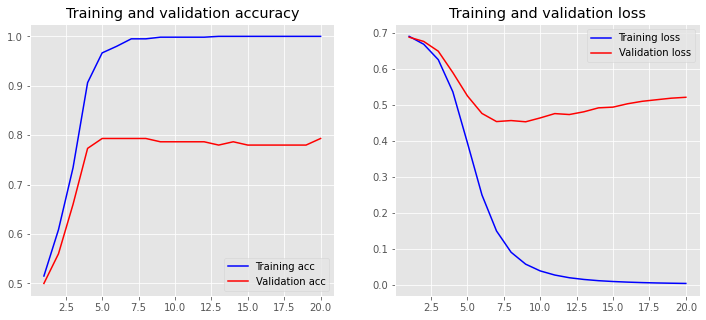

In [34]:
plot_history(history)

## Convolutional Neural Networks

In [35]:
from keras.layers import Conv1D

embedding_dim = 100
maxlen = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          266200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 331,629
Trainable params: 331,629
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print(f"Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print(f"Loss: {loss:.3f}, Accuracy: {accuracy:.3f}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 598 samples, validate on 150 samples
Epoch 1/20
598/598 [==============================] - 5s 8ms/step - loss: 0.6918 - accuracy: 0.4900 - val_loss: 0.6862 - val_accuracy: 0.5067
Epoch 2/20
598/598 [==============================] - 0s 616us/step - loss: 0.6152 - accuracy: 0.7592 - val_loss: 0.5858 - val_accuracy: 0.7333
Epoch 3/20
598/598 [==============================] - 0s 607us/step - loss: 0.3060 - accuracy: 0.9398 - val_loss: 0.4497 - val_accuracy: 0.7867
Epoch 4/20
598/598 [==============================] - 0s 617us/step - loss: 0.0713 - accuracy: 0.9916 - val_loss: 0.4703 - val_accuracy: 0.7933
Epoch 5/20
598/598 [==============================] - 0s 616us/step - loss: 0.0242 - accuracy: 0.9967 - val_loss: 0.5035 - val_accuracy: 0.8000
Epoch 6/20
598/598 [==============================] - 0s 607us/step - loss: 0.0117 - accuracy: 0.9983 - val_loss: 0.5240 - val_accuracy: 0.7800
Epoch 7/20
598/598 [==============================] - 0s 613us/step - loss: 0.0056 - accurac

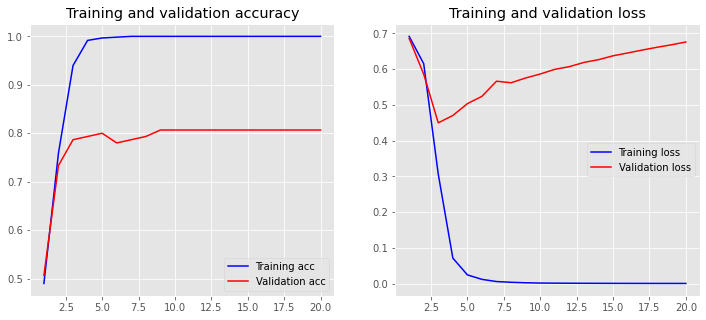

In [37]:
plot_history(history)

## Hyperparameters Optimization

In [44]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [39]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [45]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

# Run grid searcg for each source (yelp, amazon, imbd)
for source, frame in df.groupby('source'):
    print('Running grid search for data set: ', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])
    
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs,
                            batch_size=10,
                            verbose=True)
    
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set:  amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
1648/1648 [==============================] - 1s 729us/step - loss: 0.6723 - accuracy: 0.5995
Epoch 2/20
1648/1648 [==============================] - 1s 537us/step - loss: 0.3905 - accuracy: 0.8829
Epoch 3/20
1648/1648 [==============================] - 1s 529us/step - loss: 0.1365 - accuracy: 0.9600
Epoch 4/20
1648/1648 [==============================] - 1s 520us/step - loss: 0.0392 - accuracy: 0.9921
Epoch 5/20
1648/1648 [==============================] - 1s 557us/step - loss: 0.0135 - accuracy: 0.9982
Epoch 6/20
1648/1648 [==============================] - 1s 557us/step - loss: 0.0046 - accuracy: 0.9994
Epoch 7/20
1648/1648 [==============================] - 1s 527us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 8/20
1648/1648 [==============================] - 1s 525us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 9/20
1648/1648 [==============================] - 1s 584us/step - loss: 8.6673e-04 - accuracy: 1.0000
Epoch 10/20
1648/1648 [==============================] - 1s 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.2min finished


Epoch 1/20
2198/2198 [==============================] - 1s 604us/step - loss: 0.6404 - accuracy: 0.6479
Epoch 2/20
2198/2198 [==============================] - 1s 533us/step - loss: 0.3478 - accuracy: 0.8872
Epoch 3/20
2198/2198 [==============================] - 1s 533us/step - loss: 0.1363 - accuracy: 0.9604
Epoch 4/20
2198/2198 [==============================] - 1s 526us/step - loss: 0.0443 - accuracy: 0.9923
Epoch 5/20
2198/2198 [==============================] - 1s 517us/step - loss: 0.0173 - accuracy: 0.9982
Epoch 6/20
2198/2198 [==============================] - 1s 535us/step - loss: 0.0079 - accuracy: 0.9986
Epoch 7/20
2198/2198 [==============================] - 1s 535us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 8/20
2198/2198 [==============================] - 1s 519us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 9/20
2198/2198 [==============================] - 1s 518us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/20
2198/2198 [==============================] - 1s 533u

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
1648/1648 [==============================] - 1s 617us/step - loss: 0.6777 - accuracy: 0.6226
Epoch 2/20
1648/1648 [==============================] - 1s 550us/step - loss: 0.4326 - accuracy: 0.8556
Epoch 3/20
1648/1648 [==============================] - 1s 560us/step - loss: 0.1749 - accuracy: 0.9424
Epoch 4/20
1648/1648 [==============================] - 1s 522us/step - loss: 0.0551 - accuracy: 0.9915
Epoch 5/20
1648/1648 [==============================] - 1s 537us/step - loss: 0.0181 - accuracy: 0.9988
Epoch 6/20
1648/1648 [==============================] - 1s 548us/step - loss: 0.0099 - accuracy: 0.9994
Epoch 7/20
1648/1648 [==============================] - 1s 538us/step - loss: 0.0058 - accuracy: 0.9994
Epoch 8/20
1648/1648 [==============================] - 1s 559us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 9/20
1648/1648 [==============================] - 1s 537us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/20
1648/1648 [==============================] - 1s 534u

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.3min finished


Epoch 1/20
2198/2198 [==============================] - 1s 631us/step - loss: 0.6474 - accuracy: 0.6547
Epoch 2/20
2198/2198 [==============================] - 1s 531us/step - loss: 0.3398 - accuracy: 0.8758
Epoch 3/20
2198/2198 [==============================] - 1s 537us/step - loss: 0.1308 - accuracy: 0.9572
Epoch 4/20
2198/2198 [==============================] - 1s 530us/step - loss: 0.0395 - accuracy: 0.9941
Epoch 5/20
2198/2198 [==============================] - 1s 542us/step - loss: 0.0137 - accuracy: 0.9991
Epoch 6/20
2198/2198 [==============================] - 1s 536us/step - loss: 0.0073 - accuracy: 0.9995
Epoch 7/20
2198/2198 [==============================] - 1s 538us/step - loss: 0.0052 - accuracy: 0.9995
Epoch 8/20
2198/2198 [==============================] - 1s 512us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 9/20
2198/2198 [==============================] - 1s 522us/step - loss: 9.6568e-04 - accuracy: 1.0000
Epoch 10/20
2198/2198 [==============================] - 1s 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
1648/1648 [==============================] - 1s 640us/step - loss: 0.6762 - accuracy: 0.5886
Epoch 2/20
1648/1648 [==============================] - 1s 536us/step - loss: 0.3952 - accuracy: 0.8659
Epoch 3/20
1648/1648 [==============================] - 1s 558us/step - loss: 0.1281 - accuracy: 0.9660
Epoch 4/20
1648/1648 [==============================] - 1s 538us/step - loss: 0.0358 - accuracy: 0.9958
Epoch 5/20
1648/1648 [==============================] - 1s 542us/step - loss: 0.0143 - accuracy: 0.9988
Epoch 6/20
1648/1648 [==============================] - 1s 539us/step - loss: 0.0075 - accuracy: 0.9994
Epoch 7/20
1648/1648 [==============================] - 1s 555us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 8/20
1648/1648 [==============================] - 1s 533us/step - loss: 0.0024 - accuracy: 0.9994
Epoch 9/20
1648/1648 [==============================] - 1s 549us/step - loss: 9.4288e-04 - accuracy: 1.0000
Epoch 10/20
1648/1648 [==============================] - 1s 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.3min finished


Epoch 1/20
2198/2198 [==============================] - 1s 605us/step - loss: 0.6489 - accuracy: 0.6356
Epoch 2/20
2198/2198 [==============================] - 1s 538us/step - loss: 0.3461 - accuracy: 0.8740
Epoch 3/20
2198/2198 [==============================] - 1s 534us/step - loss: 0.1241 - accuracy: 0.9618
Epoch 4/20
2198/2198 [==============================] - 1s 551us/step - loss: 0.0422 - accuracy: 0.9918
Epoch 5/20
2198/2198 [==============================] - 1s 546us/step - loss: 0.0170 - accuracy: 0.9977
Epoch 6/20
2198/2198 [==============================] - 1s 543us/step - loss: 0.0065 - accuracy: 0.9995
Epoch 7/20
2198/2198 [==============================] - 1s 526us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 8/20
2198/2198 [==============================] - 1s 532us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 9/20
2198/2198 [==============================] - 1s 552us/step - loss: 7.5091e-04 - accuracy: 1.0000
Epoch 10/20
2198/2198 [==============================] - 1s 